## Mount drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Unzip dataset from drive

In [ ]:
!mkdir local_dataset
!unzip -q "/content/gdrive/My Drive/fyp-datasets/vaddem-test.zip" -d local_dataset
!ls "/content/local_dataset/dataset/face"
!mkdir output
%cd /content/output/
!mkdir generated checkpoints

1000.jpg  199.jpg  313.jpg  429.jpg  544.jpg  65.jpg   775.jpg	890.jpg
1001.jpg  19.jpg   314.jpg  42.jpg   545.jpg  660.jpg  776.jpg	891.jpg
1002.jpg  1.jpg    315.jpg  430.jpg  546.jpg  661.jpg  777.jpg	892.jpg
1003.jpg  200.jpg  316.jpg  431.jpg  547.jpg  662.jpg  778.jpg	893.jpg
1004.jpg  201.jpg  317.jpg  432.jpg  548.jpg  663.jpg  779.jpg	894.jpg
1005.jpg  202.jpg  318.jpg  433.jpg  549.jpg  664.jpg  77.jpg	895.jpg
1006.jpg  203.jpg  319.jpg  434.jpg  54.jpg   665.jpg  780.jpg	896.jpg
1007.jpg  204.jpg  31.jpg   435.jpg  550.jpg  666.jpg  781.jpg	897.jpg
1008.jpg  205.jpg  320.jpg  436.jpg  551.jpg  667.jpg  782.jpg	898.jpg
1009.jpg  206.jpg  321.jpg  437.jpg  552.jpg  668.jpg  783.jpg	899.jpg
100.jpg   207.jpg  322.jpg  438.jpg  553.jpg  669.jpg  784.jpg	89.jpg
1010.jpg  208.jpg  323.jpg  439.jpg  554.jpg  66.jpg   785.jpg	8.jpg
1011.jpg  209.jpg  324.jpg  43.jpg   555.jpg  670.jpg  786.jpg	900.jpg
1012.jpg  20.jpg   325.jpg  440.jpg  556.jpg  671.jpg  787.jpg	901.jpg
1013.jpg  

# Import libraries and functions

In [ ]:
import keras
from keras import Model
from keras.initializers import RandomNormal, Zeros
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, Dropout, Add, Conv2DTranspose, LeakyReLU, Concatenate
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D,Concatenate, Cropping2D, ZeroPadding2D
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
import random
import tensorflow as tf
import os
import tensorflow as tf
from keras.backend import set_session
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle

### TPU connection

### Initialize paths

In [ ]:
seed = 2019
np.random.seed = seed
random.seed = seed
tf.seed = seed
path = '/content/local_dataset/dataset'
face_path = '/content/local_dataset/dataset/face'
sketch_path = '/content/local_dataset/dataset/sketch'

In [ ]:
image_id_list = os.listdir(face_path)
face_id_list = os.listdir(face_path)
sketch_id_list = os.listdir(sketch_path)
image_size = (128,128)
train_path ='/content/local_dataset/dataset'
epochs = 35
validation_size = 16

# Dataset Class
Loads Dataset

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,ids,filepath,batch_size=16,image_size=(256,256),channels=3):
        self.ids=ids
        self.filepath=filepath
        self.batch_size=batch_size
        self.image_size=image_size
        self.channels=channels
        
    def __len__(self):
        return (len(self.ids)//self.batch_size)    
            
    def __getitem__(self,index):
            indexes = range(index*self.batch_size,index*self.batch_size+self.batch_size)
            ids_to_load = [self.ids[k] for k in indexes]
            X = self.__generate_x(ids_to_load)
            y = self.__generate_y(ids_to_load)
            l = []
            for i,m in enumerate(X):
                l.append(m.reshape(128,128,3))
            X = np.array(l)
            l = []
            for i,m in enumerate(y):
                l.append(m.reshape(128,128,3))
            y = np.array(l)
            return X,y
        
    def __generate_x(self,id_names):
            X = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
         
                img = cv2.imread(self.filepath+'/sketch/'+id_n)
              
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                
                img = img.astype(np.float32)/255.
                
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))

                X[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return X
        
    def __generate_y(self,id_names):
            y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                img = cv2.imread(self.filepath+'/face/'+id_n)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255.
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                y[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return y

### Load Data

In [ ]:
train_gen = DataGenerator(image_id_list[:int(len(image_id_list)*0.9)],train_path,batch_size=2,image_size=image_size,channels=3)
val_gen = DataGenerator(image_id_list[int(len(image_id_list)*0.1):],train_path,batch_size=2,image_size=image_size,channels=3)
X,y = train_gen.__getitem__(1)


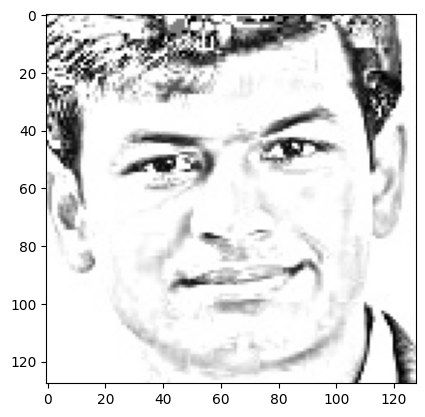

In [ ]:
plt.imshow(X[0])
plt.show()

## Initizalize parameters

In [ ]:
debug = True
input_channel = 3  # input image channels
output_channel = 3  # output image channels
lr = 0.0002
epoch = 15
batch_size = 2
combined_filepath = '/content/output/checkpoints/best_weights.h5'
generator_filepath = '/content/output/checkpoints/generator.h5'
seed = 9584
imagenet_mean = np.array([0.5, 0.5, 0.5])
imagenet_std = np.array([0.5, 0.5, 0.5])

# Define Model Architecture

### Conv block

In [ ]:
def conv_block(feature, out_channel, downsample=True, dropout=False):
    if downsample:
        x = Conv2D(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    else:
        x = Conv2DTranspose(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    return x

### U-net Generator

In [ ]:
def get_generator_unet(n_block=3):
  # with strategy.scope():
    input = Input(shape=(image_size[0], image_size[1], input_channel))
    # encoder
    e0 = Conv2D(64, kernel_size=4, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  
    e0 = BatchNormalization()(e0)
    e0 = Activation('relu')(e0)
    e1 = conv_block(e0, 128, downsample=True, dropout=False)  # 1/2
    e2 = conv_block(e1, 256, downsample=True, dropout=False)  # 1/4
    e3 = conv_block(e2, 512, downsample=True, dropout=False)  # 1/8
    e4 = conv_block(e3, 512, downsample=True, dropout=False)  # 1/16
    e5 = conv_block(e4, 512, downsample=True, dropout=False)  # 1/32
    e6 = conv_block(e5, 512, downsample=True, dropout=False)  # 1/64
    e7 = conv_block(e6, 512, downsample=True, dropout=False)  # 1/128
    # decoder
    d0 = conv_block(e7, 512, downsample=False, dropout=True)  # 1/64
    d1 = Concatenate(axis=-1)([d0, e6])
    d1 = conv_block(d1, 512, downsample=False, dropout=True)
    d2 = Concatenate(axis=-1)([d1, e5])
    d2 = conv_block(d2, 512, downsample=False, dropout=True)  # 1/16
    d3 = Concatenate(axis=-1)([d2, e4])
    d3 = conv_block(d3, 512, downsample=False, dropout=True)  # 1/8
    d4 = Concatenate(axis=-1)([d3, e3])
    d4 = conv_block(d4, 256, downsample=False, dropout=True)  # 1/4
    d5 = Concatenate(axis=-1)([d4, e2])
    d5 = conv_block(d5, 128, downsample=False, dropout=True)  # 1/2
    d6 = Concatenate(axis=-1)([d5, e1])
    d6 = conv_block(d6, 64, downsample=False, dropout=True)  # 1
    # out
    x = Conv2D(output_channel, kernel_size=3, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(d6)  
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    generator = Model(inputs=input, outputs=x)
    return generator

### Combined GAN

In [ ]:
def get_generator_training_model(generator, discriminator):
    imgA = Input(shape=(image_size[0], image_size[1], input_channel))
    imgB = Input(shape=(image_size[0], image_size[1], input_channel))
    fakeB = generator(imgA)
    realA_fakeB = Concatenate()([imgA, fakeB])
    pred_fake = discriminator(realA_fakeB)
    generator_training_model = Model(inputs=[imgA, imgB], outputs=[pred_fake, fakeB])
    return generator_training_model

### PatchGan Discriminator

In [ ]:
def get_discriminator(n_layers=4, use_sigmoid=True):
    input = Input(shape=(image_size[0], image_size[1], input_channel + output_channel))
    x = Conv2D(64, kernel_size=4, padding='same', strides=2, kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)
    x = LeakyReLU(alpha=0.2)(x)
    for i in range(1, n_layers):
        x = Conv2D(64 * 2 ** i, kernel_size=4, padding='same', strides=2, kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64 * 2 ** n_layers, kernel_size=4, padding='same', strides=1, kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=4, padding='same', strides=1, kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)
    discriminator = Model(inputs=input, outputs=x)
    return discriminator

# Initialize training loop parameters

In [ ]:
train_step_per_epoch = int(len(image_id_list)*0.8) / batch_size + 1
test_step_per_epoch = int(len(image_id_list)*0.2) / batch_size + 1
train_image_generator =  DataGenerator(image_id_list[:int(len(image_id_list)*0.8)],train_path,batch_size=batch_size,image_size=image_size,channels=3)

test_image_generator = DataGenerator(image_id_list[int(len(image_id_list)*0.8):],train_path,batch_size=batch_size,image_size=image_size,channels=3)

# Training Loop

### Initialize models and optimizers

In [ ]:
opt1 = Adam(learning_rate=lr)
opt2 = Adam(learning_rate=lr)
discriminator = get_discriminator()
print(discriminator.summary())
generator = get_generator_unet()
generator.compile(optimizer=opt2, loss='mae', metrics=['mean_absolute_percentage_error'])
print(generator.summary())
generator_train = get_generator_training_model(generator, discriminator)
print(generator_train.summary())
if os.path.exists(combined_filepath):
    generator_train.load_weights(combined_filepath, by_name=True)
    generator.load_weights(generator_filepath, by_name=True)
    print('weights loaded!')
discriminator.compile(optimizer=opt1, loss='mse', metrics=['acc'], loss_weights=None, sample_weight_mode=None)
generator_train.compile(optimizer=opt2, loss=['mse', 'mae'],
                        metrics=['mean_absolute_percentage_error'],
                        loss_weights=[1, 10])
real = np.ones((batch_size, 8, 8, 1))
fake = np.zeros((batch_size, 8, 8, 1))
best_loss = 1000

## Run Training Loop

In [ ]:
for i in range(epochs):    
    train_step = 0
    for imgA, imgB in train_image_generator:
        train_step += 1
        if train_step > train_step_per_epoch:
          # Reseting losses for train steps
            test_step = 0
            total_loss = 0
            total_mape = 0
            for imgA, imgB in test_image_generator:
                test_step += 1
                if test_step > test_step_per_epoch:
                    break
                gloss, mape = generator.test_on_batch(imgA, imgB)
                total_loss += gloss
                total_mape += mape
            break
        # Training Discriminator
        discriminator.trainable = True
        fakeB = generator.predict(imgA.reshape(batch_size,*image_size,3),verbose = 0)
        if debug:
            if train_step%200 == 0:
                fakeb = (fakeB[0] + 1) * 127.5
                fakeb = np.clip(fakeb, 0, 255)
                fakeb = fakeb.astype(np.uint8)
                fakeb = Image.fromarray(fakeb)
                fakeb.save('/content/output/generated/' + str(i + 1) + '_' + str(train_step) + '.png')
                print("{} saved".format('/content/output/generated/' + str(i + 1) + '_' + str(train_step) + '.png'))
                imgb = (imgB[0] + 1) * 127.5
                imgb = np.clip(imgb, 0, 255)
                imgb = imgb.astype(np.uint8)
                imgb = Image.fromarray(imgb)
                imgb.save('/content/output/generated/' + str(i + 1) + '_' + str(train_step) + '_real.png')
                print("{} saved".format('/content/output/generated/' + str(i + 1) + '_' + str(train_step) + '_real.png'))
                d_fake = discriminator.predict(np.concatenate((imgA, fakeB), axis=-1),verbose = 0)
                d_real = discriminator.predict(np.concatenate((imgA, imgB), axis=-1),verbose = 0)
        loss_fake, fake_acc = discriminator.train_on_batch(np.concatenate((imgA, fakeB), axis=-1), fake)
        loss_real, real_acc = discriminator.train_on_batch(np.concatenate((imgA, imgB), axis=-1), real)
        if train_step%200 == 0:
            print('epoch:{} train step:{}, loss d_fake:{:.6}, loss d_real:{:.6}, fake_acc:{:.2}, real_acc:{:.2}'.format(i + 1, train_step,loss_fake,loss_real,fake_acc,real_acc))
        # Training generator
        discriminator.trainable = False

        loss = generator_train.train_on_batch([imgA, imgB], [real, imgB])

        if train_step%200 == 0:
            print('epoch:{} train step:{} loss fool:{:.6} loss g:{:.6}'.format(i + 1, train_step, loss[1], loss[0] - loss[1]))

    # Saving Generator Weights
    generator_train.save_weights(f'/content/output/checkpoints/best_weights-{i+1}.h5', overwrite=True)
    generator.save_weights(f'/content/output/checkpoints/generator-{i+1}.h5', overwrite=True)  

# Fine Tuning With fresh discriminator

In [ ]:
opt1 = Adam(learning_rate=0.00002)
opt2 = Adam(learning_rate=0.00002)
discriminator = get_discriminator()
print(discriminator.summary())
generator = get_generator_unet()
generator.compile(optimizer=opt2, loss='mae', metrics=['mean_absolute_percentage_error'])
print(generator.summary())
generator_train = get_generator_training_model(generator, discriminator)
print(generator_train.summary())
generator.load_weights('/content/gdrive/MyDrive/fyp-datasets/generator-15.h5')
print('weights loaded!')
discriminator.compile(optimizer=opt1, loss='mse', metrics=['acc'], loss_weights=None, sample_weight_mode=None)
generator_train.compile(optimizer=opt2, loss=['mse', 'mae'],
                        metrics=['mean_absolute_percentage_error'],
                        loss_weights=[1, 10])
real = np.ones((batch_size, 8, 8, 1))
fake = np.zeros((batch_size, 8, 8, 1))
best_loss = 1000

### Freeze certain layers

In [ ]:
for layer in generator.layers[1:-2]:
  layer.trainable = False
for i in range(epochs):    
    train_step = 0
    for imgA, imgB in train_image_generator:
        train_step += 1
        if train_step > train_step_per_epoch:
            test_step = 0
            total_loss = 0
            total_mape = 0
            for imgA, imgB in test_image_generator:
                test_step += 1
                if test_step > test_step_per_epoch:
                    break
                gloss, mape = generator.test_on_batch(imgA, imgB)
                total_loss += gloss
                total_mape += mape
            break

        discriminator.trainable = True
        fakeB = generator.predict(imgA.reshape(batch_size,*image_size,3),verbose = 0)
        if debug:
            if train_step%200 == 0:
                fakeb = (fakeB[0] + 1) * 127.5
                fakeb = np.clip(fakeb, 0, 255)
                fakeb = fakeb.astype(np.uint8)
                fakeb = Image.fromarray(fakeb)
                fakeb.save('/content/output/generated/' + str(i + 1) + '_' + str(train_step) + '.png')
                print("{} saved".format('/content/output/generated/' + str(i + 1) + '_' + str(train_step) + '.png'))
                imgb = (imgB[0] + 1) * 127.5
                imgb = np.clip(imgb, 0, 255)
                imgb = imgb.astype(np.uint8)
                imgb = Image.fromarray(imgb)
                imgb.save('/content/output/generated/' + str(i + 1) + '_' + str(train_step) + '_real.png')
                print("{} saved".format('/content/output/generated/' + str(i + 1) + '_' + str(train_step) + '_real.png'))
                d_fake = discriminator.predict(np.concatenate((imgA, fakeB), axis=-1),verbose = 0)
                d_real = discriminator.predict(np.concatenate((imgA, imgB), axis=-1),verbose = 0)
        loss_fake, fake_acc = discriminator.train_on_batch(np.concatenate((imgA, fakeB), axis=-1), fake)
        loss_real, real_acc = discriminator.train_on_batch(np.concatenate((imgA, imgB), axis=-1), real)
        if train_step%200 == 0:
            print('epoch:{} train step:{}, loss d_fake:{:.6}, loss d_real:{:.6}, fake_acc:{:.2}, real_acc:{:.2}'.format(i + 1, train_step,loss_fake,loss_real,fake_acc,real_acc))
        discriminator.trainable = False
        loss = generator_train.train_on_batch([imgA, imgB], [real, imgB])
        if train_step%200 == 0:
            print('epoch:{} train step:{} loss fool:{:.6} loss g:{:.6}'.format(i + 1, train_step, loss[1], loss[0] - loss[1]))

    generator_train.save_weights(f'/content/output/checkpoints/best_weights-{i+1}.h5', overwrite=True)
    generator.save_weights(f'/content/output/checkpoints/generator-{i+1}.h5', overwrite=True)  

# Evaluation

1/1 [==============================] - 1s 513ms/step


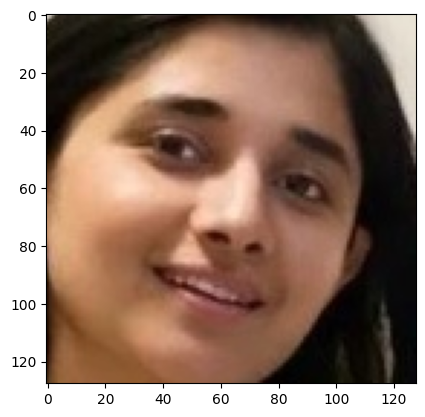

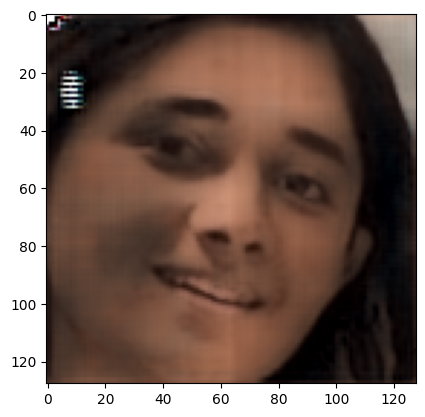

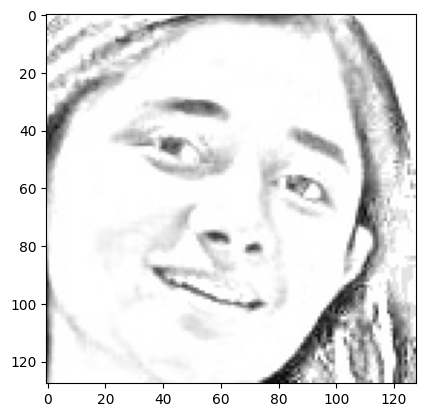

In [ ]:
X,y = val_gen.__getitem__(111)
test_model = get_generator_unet()
test_model.load_weights('/content/gdrive/MyDrive/fyp-datasets/generator-29.h5')
test_model.compile(optimizer= Adam(learning_rate=0.0002), loss='mae', metrics=['mean_absolute_percentage_error'])
y_pred = test_model.predict(X)
plt.imshow(y[1])
plt.show()
plt.imshow(y_pred[1])
plt.show()
plt.imshow(X[1])
plt.show()

In [ ]:
!mkdir test_dataset
!mkdir predicted_outputs
!unzip -q "/content/gdrive/My Drive/fyp-datasets/vaddem-test.zip" -d test_dataset
test_path='/content/output/test_dataset/dataset'
face_path_indian='/content/output/test_dataset/dataset/face'
sketch_path_indian='/content/output/test_dataset/dataset/sketch'

# Test Data Loader
image_id_list_2 = os.listdir(face_path_indian)
test_gen = DataGenerator(image_id_list_2,test_path,batch_size=2,image_size=(128,128),channels=3)


## Saving Model results

In [ ]:
%cd /content/gdrive/MyDrive/fyp-datasets

import os
import matplotlib.pyplot as plt

# Predict for every input in validation generator
for i in range(val_gen.__len__()):
    X1, y1 = val_gen.__getitem__(i)
    y_pred = test_model.predict(X1)
    for j in range(len(X1)):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
        ax[0].imshow(X1[j])
        ax[0].set_title('Input Image')
        ax[1].imshow(y1[j])
        ax[1].set_title('Ground Truth')
        ax[2].imshow(y_pred[j])
        ax[2].set_title('Predicted')
        plt.tight_layout()
        plt.savefig(f'/content/gdrive/MyDrive/fyp-datasets/predicted_outputs_2/image_{i*len(X1)+j}.jpg')
        plt.close()

In [ ]:
from google.colab import files
import shutil

shutil.make_archive('/content/output/checkpoints','zip','/content/output/checkpoints')
files.download('/content/output/checkpoints')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Saving Results in FID format

In [ ]:
%cd /content/gdrive/MyDrive/fyp-datasets/fid_outputs

import matplotlib as mpl
count = 0
for i in range(val_gen.__len__()):
    X1, y1 = val_gen.__getitem__(i)
    y_pred = test_model.predict(X1)
    for j in range(len(X1)):
        count+=1
        mpl.rcParams[ 'figure.figsize' ] = ( 1, 1 )
        mpl.rcParams[ 'figure.dpi' ] = 128
        fig = plt.imshow(y_pred[j])
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f'generated/{count}.jpg', bbox_inches='tight', pad_inches = 0,dpi = 128)
        fig = plt.imshow(y1[j])
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f'real/{count}.jpg', bbox_inches='tight', pad_inches = 0,dpi = 128)
        print(count)

## Calculating FID score

In [ ]:
from scipy import linalg
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.utils import load_img
from keras.utils import img_to_array

num_generated_images=os.listdir('generated')
num_real_images=os.listdir('real')

def calculate_fid(images1, images2):
    # Load the InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    # Preprocess the images for the InceptionV3 model
    images1 = preprocess_images(images1)
    images2 = preprocess_images(images2)
    # Generate the feature vectors for the real and generated images
    features1 = model.predict(images1)
    features2 = model.predict(images2)
    # Calculate the mean and covariance of the feature vectors
    mean1, cov1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mean2, cov2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)
    # Calculate the squared distance between the means
    ssdiff = np.sum((mean1 - mean2)**2.0)
    # Calculate the trace of the product of the covariances
    covmean = linalg.sqrtm(cov1.dot(cov2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(cov1 + cov2 - 2.0*covmean)
    return fid

def preprocess_images(images):
    # Resize and normalize the images for the InceptionV3 model
    images = tf.image.resize(images, (299, 299))
    images = tf.keras.applications.inception_v3.preprocess_input(images)
    return images.numpy()

# Load the real and generated images
real_images = []
generated_images = []

for i in num_real_images[:380] :
    img = load_img('generated/'+ i)
    img = img_to_array(img)
    real_images.append(img)

for i in num_real_images[:380] :
    img = load_img('real/'+i)
    img = img_to_array(img)
    generated_images.append(img)

real_images = np.array(real_images)
generated_images = np.array(generated_images)
# Calculate the FID score
fid = calculate_fid(real_images, generated_images)
print('FID score:', fid)

87910968/87910968 [==============================] - 5s 0us/step <br/>
12/12 [==============================] - 3s 105ms/step <br/>
12/12 [==============================] - 0s 22ms/step <br />
FID score: 55.484877747701056

### Utility

In [ ]:
import numpy as np
import keras.utils as image
X = np.zeros((1,image_size[0],image_size[1],3))
orig = np.zeros((1,image_size[0],image_size[1],3))
imgs = cv2.imread('/content/test.jpg')
imgs = cv2.resize(imgs,(128,128))
imgs_gray = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
img_invert = 255 - imgs_gray
img_smoothing = cv2.GaussianBlur(img_invert, ksize=(21, 21),sigmaX=0, sigmaY=0)
final = cv2.divide(imgs_gray, 255 - img_smoothing, scale=256)
cv2.imwrite("/content/processed.jpg",final)
img = cv2.imread('/content/processed.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img = img.astype(np.float32)/255.

img = cv2.resize(img,(image_size[0],image_size[1]))
original = cv2.imread('/content/test.jpg')
original = cv2.resize(original,(128,128))
original = cv2.cvtColor(original,cv2.COLOR_BGR2RGB)

original = original.astype(np.float32)/255.
X[0,:,:,:] = img.reshape(image_size[0],image_size[1],3)
orig[0,:,:,:] = original.reshape(image_size[0],image_size[1],3)
res = test_model.predict(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(orig[0])
ax[0].set_title('Input Image')
ax[1].imshow(res[0])
ax[1].set_title('Produced Result')

plt.tight_layout()
plt.savefig(f'/content/image_good_sketch.jpg')
plt.close()

1/1 [==============================] - 0s 36ms/step


# END